<a href="https://colab.research.google.com/github/nyluje/RCP209DeeplabExperiment/blob/main/RCP209_Deeplab_PyTorch_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [61]:
%cd /content
!git clone https://github.com/pytorch/vision

!cp /content/vision/references/segmentation/utils.py /content/


/content
fatal: destination path 'vision' already exists and is not an empty directory.


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.nn import parameter
#from torchvision import models
from torchsummary import summary
#import torchsummary
from torch import cuda
from torchvision.datasets import VOCSegmentation

from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Subset

import os
import time
import datetime
import random

#importation d'un model deeplab prédéfini
model_dl=models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)

#https://github.com/pytorch/vision/blob/main/torchvision/models/segmentation/deeplabv3.py definition 
"""
        backbone (nn.Module): the network used to compute the features for the model.
            The backbone should return an OrderedDict[Tensor], with the key being
            "out" for the last feature map used, and "aux" if an auxiliary classifier
            is used.
        classifier (nn.Module): module that takes the "out" element returned from
            the backbone and returns a dense prediction.
        aux_classifier (nn.Module, optional): auxiliary classifier used during training
"""
#backbone correspondond au modèle de base, 
#print(dlv3mnv3l.backbone.__get_item__(dlv3mnv3l.backbone.__len__()-1))
print(f"base model backbone, on top of wich DeepLab is built is composed of {model_dl.backbone.__len__()} layers")

#classifier concerne la partie deeplab: DeepLabHead dans laquelle on retrouve la convolution à trou
print(model_dl.classifier[model_dl.classifier.__len__()-1])

#et également classifier auxiliaire utilisé dans l'inception.
print(model_dl.aux_classifier)

#fonction pour bloquer le calcul de gradient d'un model ou d'une partie d'un model
def set_parameters_requires_grad(model,feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

#fonction pour compter les paramètres bloqués ou non d'un model ou d'une partie d'un model
def display_count_grad_val_true_and_false_parameters(model):
  counttrue=0
  countfalse=0
  for param in model.parameters():
    if param.requires_grad is True:
      counttrue+=1
    else:
      countfalse+=1
  print(f'On model {model.__class__.__name__}, alterable gradient parameters number is {counttrue},blocked gradient parameters number is: {countfalse}')


display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)



block_parameters=True
if block_parameters is True:
  print(model_dl.classifier[model_dl.classifier.__len__()-1])
  set_parameters_requires_grad(model_dl.backbone,True)
  set_parameters_requires_grad(model_dl.aux_classifier,True)
  print(model_dl.classifier[model_dl.classifier.__len__()-1].in_channels)
  set_parameters_requires_grad(model_dl.classifier[0],True)

set_to_zero_weight=False
for layer_num in range(model_dl.classifier.__len__()):
  print(f'layer {layer_num}, val:{model_dl.classifier[layer_num]}')
  for name, param in model_dl.classifier[layer_num].named_parameters():
    print(f'name {name} grad {param.requires_grad}')
    ####set param to 0
    if set_to_zero_weight is True:
      param.data.fill_(0.01)


display_count_grad_val_true_and_false_parameters(model_dl.backbone)
display_count_grad_val_true_and_false_parameters(model_dl.classifier)
display_count_grad_val_true_and_false_parameters(model_dl.aux_classifier)


Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


base model backbone, on top of wich DeepLab is built is composed of 17 layers
Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
FCNHead(
  (0): Conv2d(40, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(10, 21, kernel_size=(1, 1), stride=(1, 1))
)
On model IntermediateLayerGetter, alterable gradient parameters number is 170,blocked gradient parameters number is: 0
On model DeepLabHead, alterable gradient parameters number is 23,blocked gradient parameters number is: 0
On model FCNHead, alterable gradient parameters number is 5,blocked gradient parameters number is: 0
Conv2d(256, 21, kernel_size=(1, 1), stride=(1, 1))
256
layer 0, val:ASPP(
  (convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(960, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [40]:


dataset_dir_root="/content/drive/MyDrive/RCP209/datasets"
specific_dataset_dir='VOCdevkit'
vocDevkitNeedToBeDownloaded = not os.path.isdir(os.path.join(dataset_dir_root,specific_dataset_dir))

"""
vocSegDatasetTrain = VOCSegmentation(root=datasetDirRoot,image_set='train',year='2012'
                                ,download=vocDevkitNeedToBeDownloaded
                                )
print(vocSegDatasetTrain.__len__())
pic = vocSegDatasetTrain.__getitem__(100)
showImageReady(pic[1])
showImageReady(pic[0])
dataloaderTrain = DataLoader(vocSegDatasetTrain,batch_size=4,shuffle=True)
"""


number_of_elements_in_subset=4


#pour pouvoir les grouper par batch 
#(c'est à dire: plusieurs images dans un même tenseur dont la première dimension correspond au nombre d'image dans le batch)
#les images seront toutes transformées (déformées) avec la taille standard de 128 sur 128 pixels              
#base_size=128 
base_size=32 
transform_to_apply_on_input_data=T.Compose(
                                    [
                                     T.Resize(size=(base_size,base_size)), #De https://github.com/pytorch/vision/blob/main/references/segmentation/presets.py
                                     T.PILToTensor(),
                                     T.ConvertImageDtype(torch.float)
                                     ##,T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                                     ]
                                    )

transform_to_apply_on_target_data = T.Compose([
                                               T.Resize(size=(base_size,base_size))
                                               ,T.PILToTensor()
                                               ,T.ConvertImageDtype(torch.long)
                                               ])

vocSegDataset= {}
#chargement des datasets d'entrainement et de validation
vocSegDataset= {image_set_tag: VOCSegmentation(root=dataset_dir_root,image_set=image_set_tag,year='2012'
                                ,download=vocDevkitNeedToBeDownloaded
                                ,transform=transform_to_apply_on_input_data
                                ,target_transform=transform_to_apply_on_target_data
                                )
                for image_set_tag in ['train','val']}
#réduction du dataset en sous ensemble pour diminuer les temps de cacul dans la phase de rédaction et tests itératifs du code
vocSegDataset = {image_set_tag:
                 Subset(
                     vocSegDataset[image_set_tag],
                     random.sample(list(range(0, vocSegDataset[image_set_tag].__len__(), 1)),number_of_elements_in_subset))
                 for image_set_tag in ['train','val']}

#creation des dataloaders par batch
num_workers_available = os.cpu_count()
dataloaders_dict = {x: DataLoader(vocSegDataset[x],batch_size=4,shuffle=True,num_workers=num_workers_available) for x in ['train','val']}



for tag in dataloaders_dict:
  start_time = time.time()
  print(f'dataloaders_dict {tag} has {dataloaders_dict[tag].__len__()} batches made of {dataloaders_dict[tag].batch_size} group of 2 tensors reprensenting each input image and ground truth target segmentation,') 
  number_of_images=0
  for idx,val in enumerate(dataloaders_dict[tag]):
    number_of_images += val[0].shape[0]
    if idx in range(0,2): #impression des 
      print(f"At index {idx}, Input tensor shape is:  {val[0].shape}, Segmentation target tensor shape is:  {val[1].shape}")
  total_time= time.time()-start_time
  total_time_str=str(datetime.timedelta(seconds=int(total_time)))
  print(f'Time to iterate thru  {dataloaders_dict[tag].__len__()} batches, representing a total of {number_of_images} images, was: {total_time_str}')




dataloaders_dict train has 1 batches made of 4 group of 2 tensors reprensenting each input image and ground truth target segmentation,
At index 0, Input tensor shape is:  torch.Size([4, 3, 32, 32]), Segmentation target tensor shape is:  torch.Size([4, 1, 32, 32])
Time to iterate thru  1 batches, representing a total of 4 images, was: 0:00:03
dataloaders_dict val has 1 batches made of 4 group of 2 tensors reprensenting each input image and ground truth target segmentation,
At index 0, Input tensor shape is:  torch.Size([4, 3, 32, 32]), Segmentation target tensor shape is:  torch.Size([4, 1, 32, 32])
Time to iterate thru  1 batches, representing a total of 4 images, was: 0:00:04


In [5]:
import torch.optim as optim

#met le modèle dans le GPU
print(device)
model_dl = model_dl.to(device)

param_to_update = model_dl.parameters()
print(param_to_update)
print("Params to learn:")
feature_extract=True #si vrai mise à jour des coucher de la fin
if feature_extract:
  params_to_update=[]
  for name, param in model_dl.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)
else:
  for name,param in model_dl.named_parameters():
    if param.requires_grad==True:
      print("\t",name)
print(params_to_update)

#utilisation de l'optimizer descente de gradient stochastique, 
#lr: correspond au learning rate, ou taux d'apprentissage,
# et momemtum est le facteur permettant de pondérer la dynamique de variation du gradient en tenant compte des valeurs précédente dans l'itération
optimizer_ft = optim.SGD(params_to_update,lr=0.001,momentum=0.9) #to check in other exampled what optimizer is used

cuda:0
<generator object Module.parameters at 0x7f1320b66b50>
Params to learn:
	 classifier.1.weight
	 classifier.2.weight
	 classifier.2.bias
	 classifier.4.weight
	 classifier.4.bias
[Parameter containing:
tensor([[[[ 7.3231e-04, -5.9317e-03, -2.1712e-02],
          [ 1.4271e-02, -1.4853e-02, -1.7889e-02],
          [-2.2055e-02,  7.3495e-03, -2.1319e-02]],

         [[-1.8751e-02, -2.9860e-03, -5.5475e-03],
          [-2.1546e-02,  1.9520e-03,  1.3837e-02],
          [-1.9878e-02, -1.5890e-02,  1.7438e-02]],

         [[ 1.2064e-02, -1.1520e-02, -1.5955e-02],
          [ 8.1964e-03,  1.8916e-02,  5.8786e-03],
          [ 3.4711e-04, -9.7348e-03, -4.9882e-03]],

         ...,

         [[ 2.7533e-02,  9.6158e-04, -2.4650e-03],
          [ 1.9990e-02,  1.8172e-02, -1.0827e-03],
          [ 2.3451e-02,  7.9360e-03,  1.4367e-02]],

         [[ 4.3577e-03, -2.1137e-02,  1.3002e-03],
          [ 5.1617e-03,  1.0659e-02, -9.9504e-03],
          [-1.2147e-03, -4.6200e-03,  1.4766e-02]],

  

In [47]:
from torchvision.models.segmentation.deeplabv3 import DeepLabV3
#print(dlv3mnv3l)
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

#import utils

import time
import copy
#la fonction train model gere l'entrainement et la validation d'un modele donné. Il prend en entrée:
# - un model PyTorch
# - un dictionnaire de données chargées
# - une fonction de perte
# - un optimizer
# - un nombre défini de tour d'entrainement et validation (epoch)
# - et un flag boolean pour les modèles d'inception (inception_v3)
def train_model(model, dataloaders, lossfunction, optimizer, num_epochs=10,is_inception=False):
  since = time.time()
  val_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc=0.0
  for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs-1}")
    #print('-'*10)

    #chaque epoch a une phase d'entrainement et de validation
    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      running_loss =0.0
      running_corrects=0

      print(f"phase is {phase}, dl phase {dataloaders[phase]}")
      print(f"dl test {enumerate(dataloaders[phase])}")
      #print(f"dl test {dataloaders[phase].generator}")

      #Itération sur les données
      for input, target in dataloaders[phase]:
#      for inputs, labels in dataloaders[phase]:
        print(f"loop test {input.shape}")
        input= input.to(device) 
        target = target.to(device)

        tim = T.ToPILImage()(target[2])
        showImageReady(tim)

        print(f'before squeezz op {target.shape}')
        target=target.squeeze(1) #https://discuss.pytorch.org/t/semantic-segmentation-loss-function/48431/3
        print(f'after squeezz op {target.shape}')

        #zero the parameter gradients
        optimizer.zero_grad()

        #forward
        #track history if only in train
        with torch.set_grad_enabled(phase=='train'):
          #récupération du model en sortie et calcul de la perte
          #cas spécial pour l'inception car en entrainement il y a une sortie auxiliaire. En entrainement, la perte est calculée 
          #sur la sortie finale et les sorties auxiliaires
          #mais en sortie seulement la sortie finale est considérée
          if is_inception and phase == 'train':
            #pas implémenter pous l'instant
            output, aux_output = model(input)['out']
            loss1 = lossfunction(output, target)
            loss2 = lossfunction(aux_output, target)
            loss = loss1 + 0.4*loss2
          else:
            output = model(input)['out']
              #print(output.shape)
              
              
              #print(target[3]) # prints the whole tensor
            im = T.ToPILImage()(input[2])
            showImageReady(im)

            #print(f"target {target[2]}")
            #print(f"target data {target.data}")
            
            #sem_classes = ['__background__','airplane','bike','bird','boat','bottle','bus','car','cat','chair','cow','table','dog','horse','motobike','human','pottedplant','sheep','sofa','train','tv']
            #sem_class_to_idx ={cls: idx for (idx,cls) in enumerate(sem_classes)}
            #normalized_masks = torch.nn.functional.softmax(output[2], dim=1)
            #print(normalized_masks.shape) #nombre d'image dans le batch
            #masks = [
            #  normalized_masks[sem_class_to_idx[cls]]
            #  for cls in sem_classes
            #]
            #for index, i in enumerate(masks):
            #  print(sem_classes[index])
            #  showImage(i)


#              class_dim=1
#              print(f'sem_class_to_idx[boat] is {sem_classes[4]} {sem_class_to_idx["boat"]} ')#; masks[sem_class_to_idx[boat]] = {masks[sem_classes[4]]} ')


#              boolean_boat_masks= (masks[sem_class_to_idx['boat']].argmax(class_dim)==sem_class_to_idx['boat'])
#              print(f"shape = {boolean_boat_masks.shape}, dtype ={boolean_boat_masks.dtype}")



            print(f'output.shape {output.shape}, target.shape {target.shape}')
            loss = lossfunction(output, target) 
            print(f"loss {loss}")

          _, preds = torch.max(output,1)

              
          #optimisation seulement en phase d'entrainement
          if phase == 'train':
            print("goback")
            loss.backward()
            optimizer.step()
            print("opti step ok")
          running_loss += loss.item() * input.size(0)
          running_corrects += torch.sum(preds == target.data)
          #running_corrects += torch.sum(input = target)

          torch.set_printoptions(profile="full")
          print(f"preds 1st { _.shape } , preds {preds[0]}")
          print(f"target data = {target.data[0]}")
          print(f"running correcst = {running_corrects}")
          torch.set_printoptions(profile="default") # reset


          #try confmat
          print(f'target.flatten().max() {target.flatten().max()}')
          print(f'output.argmax(1).flatten() {output.argmax(1).flatten().max()}')

          #confmat = utils.ConfusionMatrix(21)
          #confmat.update(target.flatten(),output.argmax(1).flatten())
          #confmat.reduce_from_all_processes()
          #print(f"confmat is {confmat}")

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print(f"{phase} loss= {epoch_loss:.4f} acc = {epoch_acc:.4f}")
        
        #conserver le modèle qui a donné les meilleures performances
        if phase == "val" and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        if phase == 'val':
          val_acc_history.append(epoch_acc)


  time_elapsed = time.time() - since
  print(f"training complete in {time_elapsed//60:.0f}m{time_elapsed % 60}")
  print(f"Best val acc= {best_acc:4f}")

  #chargement des meilleurs poids du model
  model.load_state_dict(best_model_wts)
    


  return model, val_acc_history
    

loss_function = torch.nn.CrossEntropyLoss(ignore_index=255)
model_ft, hist = train_model(model_dl,dataloaders_dict,loss_function, optimizer_ft, num_epochs=1)


Epoch 0/0
phase is train, dl phase <torch.utils.data.dataloader.DataLoader object at 0x7f1313743910>
dl test <enumerate object at 0x7f1312708fa0>
loop test torch.Size([4, 3, 32, 32])


AttributeError: ignored

torch.Size([1, 21, 375, 500])


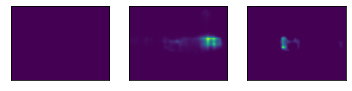

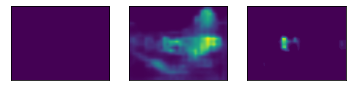

In [52]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
from torchvision.transforms.functional import convert_image_dtype


model_dl.eval()
image_location= "VOC2012/JPEGImages"
imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_location))

testimg = read_image(str(imagepath/'2008_006903.jpg'))
#grid = make_grid([testimg,testimg])
#showImage(grid)


#vocSegDatasetTesting= VOCSegmentation(root=dataset_dir_root,image_set="val",year='2012'
#                                ,download=vocDevkitNeedToBeDownloaded
#                                )
#dataloaders_dict.update(num_workers=0)
#dataloadersTesting = DataLoader(vocSegDatasetTesting,batch_size=1,shuffle=False,num_workers=1)

#for input, target in dataloadersTesting:
#  input.to(device)
#dataloadersTesting[0].to(device)
#print(vocSegDatasetTesting.__len__())

#print(vocSegDatasetTesting[0])

#testimg= vocSegDatasetTesting[0].to(device)

batch_int = torch.stack([testimg])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model_dl.to('cpu')

output = model_dl(batch)['out']


sem_classes = ['__background__','airplane','bike','bird','boat','bottle','bus','car','cat','chair','cow','table','dog','horse','motobike','human','pottedplant','sheep','sofa','train','tv']
sem_class_to_idx ={cls: idx for (idx,cls) in enumerate(sem_classes)}
normalized_masks = torch.nn.functional.softmax(output, dim=1)
print(normalized_masks.shape) #nombre d'image dans le batch
#print(normalized_masks) #nombre d'image dans le batch

dog_and_boat_masks = [
  normalized_masks[img_idx,sem_class_to_idx[cls]]
  for img_idx in range(batch.shape[0])
  for cls in ('dog','boat','human')
]
showImage(dog_and_boat_masks)

model_not_changed = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)
model_not_changed.eval()
output_not_changed = model_not_changed(batch)['out']
normalized_masks_not_changed = torch.nn.functional.softmax(output_not_changed, dim=1)
dog_and_boat_masks_not_changed = [
  normalized_masks_not_changed[img_idx,sem_class_to_idx[cls]]
  for img_idx in range(batch.shape[0])
  for cls in ('dog','boat','human')
]
showImage(dog_and_boat_masks_not_changed)


In [ ]:
test = [
        {"params": [p for p in model_dl.backbone.parameters() if p.requires_grad]},
        {"params": [p for p in model_dl.classifier.parameters() if p.requires_grad]},
    ]
print(test[1]["params"].__len__())
#for x in range(0,test.__len__()):
#  print(test[x])

#print('toto')


5


In [ ]:
#from torchvision.models.segmentation.deeplabv3 import 
from torchvision import models

for i in dir(models): print(i)


AlexNet
DenseNet
EfficientNet
GoogLeNet
GoogLeNetOutputs
Inception3
InceptionOutputs
MNASNet
MobileNetV2
MobileNetV3
RegNet
ResNet
ShuffleNetV2
SqueezeNet
VGG
_GoogLeNetOutputs
_InceptionOutputs
__builtins__
__cached__
__doc__
__file__
__loader__
__name__
__package__
__path__
__spec__
_utils
alexnet
densenet
densenet121
densenet161
densenet169
densenet201
detection
efficientnet
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
feature_extraction
googlenet
inception
inception_v3
mnasnet
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mobilenetv2
mobilenetv3
quantization
regnet
regnet_x_16gf
regnet_x_1_6gf
regnet_x_32gf
regnet_x_3_2gf
regnet_x_400mf
regnet_x_800mf
regnet_x_8gf
regnet_y_16gf
regnet_y_1_6gf
regnet_y_32gf
regnet_y_3_2gf
regnet_y_400mf
regnet_y_800mf
regnet_y_8gf
resnet
resnet101
resnet152
resnet18
resnet34
resnet50
resnext101_32x8d
resnext5

In [ ]:
!pip install torchsummary

Pour commencer un model précontruit est sélectionné parmi le package `torchvision.models`. Le modèle DeepLab v3 construit sur le mobilenet est sélectionné `deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)` , le paramètre `pretrained` permet d'utiliser des poids déjà entrainés, le paramètre `progress`permet de spécifié si l'utilisateur souhaite voir la barre de progrès lors du chargement du modèle.

In [6]:
#https://pytorch.org/vision/0.12/auto_examples/plot_visualization_utils.html#semantic-seg-output

#utlitaire de visualisation
import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'

def showImage(images):
  if not isinstance(images,list): #controle qu'une liste soit bien passée, si c'est une image unique elle est insérér dans un tableau
    images=[images]
  fix, axs = plt.subplots(ncols=len(images),squeeze=False)
  for i, image in enumerate(images):
    #print(i)
    #print(dir(image))
    image=image.detach()
    image=F.to_pil_image(image)
    axs[0,i].imshow(np.asarray(image))
    axs[0,i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


def showImageReady(images):
  if not isinstance(images,list): #controle qu'une liste soit bien passée, si c'est une image unique elle est insérér dans un tableau
    images=[images]
  fix, axs = plt.subplots(ncols=len(images),squeeze=False)
  for i, image in enumerate(images):
    #print(i)
    #print(dir(image))
#    image=image.detach()
#    image=F.to_pil_image(image)
    axs[0,i].imshow(np.asarray(image))
    axs[0,i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



#get data and train the last layer of the model
#normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            #     std=[0.229, 0.224, 0.225])




In [ ]:
!ls /content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012/JPEGImages/2008_006902.jpg

ls: cannot access '/content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012/JPEGImages/2008_006902.jpg': No such file or directory


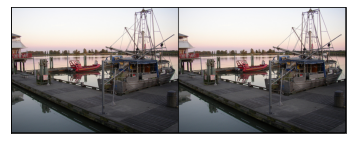

In [21]:
#visualisation d'une grille d'images
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path


image_location= "VOC2012/JPEGImages"
imagepath = Path(os.path.join(dataset_dir_root,specific_dataset_dir,image_location))

testimg = read_image(str(imagepath/'2008_006903.jpg'))
grid = make_grid([testimg,testimg])
showImage(grid)

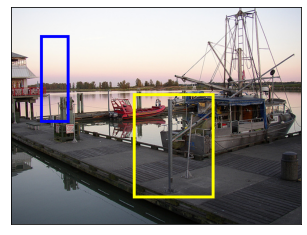

In [22]:
#bounding boxes
from torchvision.utils import draw_bounding_boxes
boxes = torch.tensor([[50,50,100,200],[210,150,350,330]],dtype=torch.float)
colors=['blue','yellow']
result = draw_bounding_boxes(testimg,boxes,colors=colors,width=5)
showImage(result)

In [23]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms.functional import convert_image_dtype
batch_int = torch.stack([testimg])
batch = convert_image_dtype(batch_int, dtype=torch.float)

model = fasterrcnn_resnet50_fpn(pretrained=True,progress=False)
evaluationProvidedByModel = model.eval()

outputs = evaluationProvidedByModel(batch)
print(outputs)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[{'boxes': tensor([[ 25.6714, 196.7924,  52.8190, 214.1130],
        [171.4736, 156.0438, 266.5989, 194.4975],
        [275.4010, 144.4845, 340.5992, 179.2980],
        [246.5744,   3.3199, 488.0864, 263.3842],
        [192.7297, 139.3143, 472.5115, 279.3448],
        [275.9847, 140.9954, 414.2402, 184.5185],
        [171.1855, 159.8380, 212.5408, 189.4283],
        [269.8184, 141.2919, 480.2721, 226.6021],
        [430.3775,  98.6996, 491.5742, 228.6742],
        [251.3534, 159.3800, 259.0671, 174.7318],
        [  0.6947, 152.7787, 483.6465, 341.8044],
        [276.4509, 145.7898, 340.6919, 175.7650],
        [160.4514, 156.3094, 275.5633, 238.3539],
        [ 43.1193, 191.9486,  62.7974, 201.3487],
        [186.7081, 174.9394, 265.6221, 196.0210],
        [264.8405, 172.1904, 470.5372, 265.5232],
        [167.9534, 182.4112, 185.3697, 192.4759],
        [441.8027, 172.1865, 490.4497, 226.1332],
        [188.5546, 169.6265, 266.9994, 188.2016],
        [289.3830,   2.3953, 484.2342, 

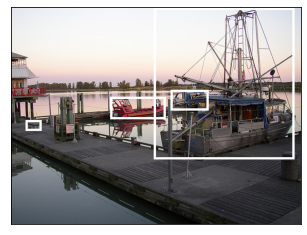

In [ ]:
score_threshold = .8
test_boxes = [draw_bounding_boxes(img_from_batch, boxes=output['boxes'][output['scores']>score_threshold],width=4) for img_from_batch, output in zip(batch_int,outputs)]
showImage(test_boxes)

torch.Size([1, 21, 375, 500]) -6.063498020172119 17.853588104248047
torch.Size([1, 21, 375, 500]) -5.691900730133057 15.871671676635742


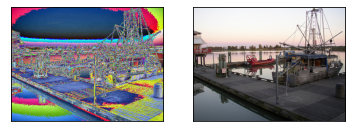

In [24]:
#masque de segmentation

from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

model = deeplabv3_mobilenet_v3_large(pretrained=True,progress=False)
segmentationEval = model.eval()

batch_normalisation = F.normalize(batch, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
output = model(batch_normalisation)['out']
outputNotNormalized = model(batch)['out']
print(outputNotNormalized.shape,outputNotNormalized.min().item(),outputNotNormalized.max().item())
print(output.shape,output.min().item(),output.max().item())
#La sortie de la segmentation par le modèle est un tenseur contenant la taille du batch, le nombre de classes, la hauteur et largeur. 
#Les valeurs ne sont pas un score normalisé, il peut être normalisé entre [0,1] en utilisant une fonction softmax. 
#Après la softmax, chaque valeur peut être interprété  comme une probabilité d'un pixel d'appartenir à une classe donnée

#print(batch_normalisation)
#print(batch)
from torchvision.transforms import ToPILImage
backNorm=ToPILImage()(batch_normalisation[0])
backNotNorm=ToPILImage()(batch[0])
showImageReady([backNorm,backNotNorm])
#fix, axs = plt.subplots(ncols=1,squeeze=False)
#axs[0,0].imshow(np.asarray(back))
#axs[0,0].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])


#fix, axs = plt.subplots(ncols=1,squeeze=False)
#axs[0,0].imshow(np.asarray(backNotNorm))
#axs[0,0].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[])



torch.Size([1, 21, 375, 500])


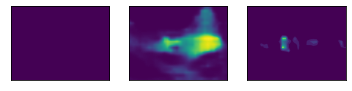

In [25]:
#mask détecté pour classe bateau et chien
sem_classes = ['__background__','airplane','bike','bird','boat','bottle','bus','car','cat','chair','cow','table','dog','horse','motobike','human','pottedplant','sheep','sofa','train','tv']
sem_class_to_idx ={cls: idx for (idx,cls) in enumerate(sem_classes)}
#print(sem_class_to_idx['boat'])
#print(batch.shape[0]) #nombre d'image dans le batch
normalized_masks = torch.nn.functional.softmax(output, dim=1)
print(normalized_masks.shape) #nombre d'image dans le batch
#print(normalized_masks) #nombre d'image dans le batch

dog_and_boat_masks = [
  normalized_masks[img_idx,sem_class_to_idx[cls]]
  for img_idx in range(batch.shape[0])
  for cls in ('dog','boat','human')
]
showImage(dog_and_boat_masks)


tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])
shape = torch.Size([1, 375, 500]), dtype =torch.bool


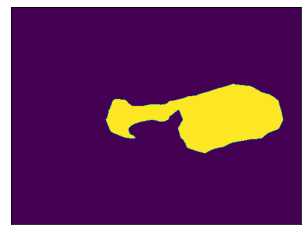

In [26]:
class_dim=1
boolean_boat_masks= (normalized_masks.argmax(class_dim)==sem_class_to_idx['boat'])
print(boolean_boat_masks)
print(f"shape = {boolean_boat_masks.shape}, dtype ={boolean_boat_masks.dtype}")
showImage([m.float() for m in boolean_boat_masks])

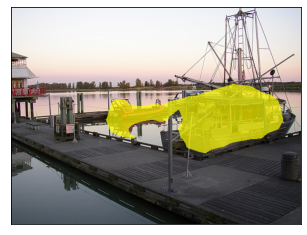

In [ ]:
from torchvision.utils import draw_segmentation_masks
boat_with_masks = [
    draw_segmentation_masks(img, masks=mask, alpha=0.7,colors='yellow')
    for img, mask in zip(batch_int, boolean_boat_masks)
]
showImage(boat_with_masks)

#autres example https://pytorch.org/vision/0.12/auto_examples/plot_visualization_utils.html#semantic-seg-output

torch.Size([1, 21, 375, 500])
boat1_masks_shape = torch.Size([21, 375, 500]),dtype=torch.float32
boat1_all_classes_masks = torch.Size([21, 375, 500]),dtype=torch.bool


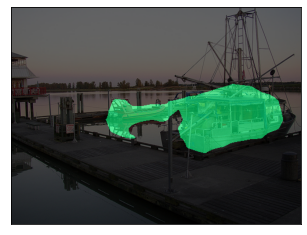

In [ ]:
print(normalized_masks.shape)
num_classes=normalized_masks.shape[1]
boat1_masks=normalized_masks[0]
class_dim=0
#torch.set_printoptions(profile="full")
#print(boat1_masks.argmax(class_dim))
#torch.set_printoptions(profile="default")
#torch.set_printoptions(precision=1)
#print(boat1_masks[4])

#print(torch.arange(num_classes)[:,None,None])
boat1_all_classes_masks=boat1_masks.argmax(class_dim)==torch.arange(num_classes)[:,None,None]
print(f"boat1_masks_shape = {boat1_masks.shape},dtype={boat1_masks.dtype}")
print(f"boat1_all_classes_masks = {boat1_all_classes_masks.shape},dtype={boat1_all_classes_masks.dtype}")

boat_with_all_masks = draw_segmentation_masks(testimg,masks=boat1_all_classes_masks, alpha=.6)
showImage(boat_with_all_masks)

In [ ]:
#exemple pour comprender boat1_masks.argmax(class_dim) ->cela renvoie l'argument max par rapport sur une des dimensions du tenseur (https://deeplizard.com/learn/video/K3lX3Cltt4c)

t = torch.tensor([
    [1,0,0,2],
    [0,3,3,0],
    [4,0,0,5]
], dtype=torch.float32)
#print(t.max())
#print(t.argmax())
#print(t.flatten())
#print(t.max(0))
print(t.argmax(0))
#print(t.flatten(0))


Entrainement du model

In [ ]:
!ls /content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012

ls: cannot access '/content/drive/MyDrive/RCP209/datasets/pascal_voc_seg/VOC2012': No such file or directory


In [ ]:
CustomDataset(csv_file='')

In [ ]:
!git clone https://github.com/msminhas93/DeepLabv3FineTuning

In [ ]:
%cd DeepLabv3FineTuning
!pip install -r requirements.txt


In [ ]:
!python main.py --data-directory CrackForest --exp_directory CFExp


In [ ]:
#https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html
#https://github.com/meetps/pytorch-semseg/blob/master/ptsemseg/loader/pascal_voc_loader.py


from pandas._libs.tslibs.conversion import localize_pydatetime
from numpy.ma.core import logical_and
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import pandas as pd
import os
import numpy as np
#from skimage import io, transform
import collections
from PIL import Image
from torchvision import transforms

class pascalVOCDataset(Dataset):
  """
    5 splits sont fournis pour travailler avec VOC data
    train: voc 2012 train data 1464 images
    val: voc 2012 validation data 1449 images
    trainval: train+val 2913 images
    train_aug: 8829 images
    train_aug_val: voc2012 validation data moins image de train_aug
  """
  def __init__(self, root_dir, sbd_path=None,split='train_aug', is_transform=False, img_size=512, 
               augmentations=None, img_norm=True,test_mode=False):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.root_dir= root_dir
    self.sbd_path = sbd_path
    self.is_transform = is_transform
    self.augmentations = augmentations
    self.img_norm= img_norm
    self.test_mode = test_mode
    self.n_classes = 21
    self.mean=np.array([104.00699, 116.66877, 122.67892])
    self.files=collections.defaultdict(list)
    self.img_size= img_size if isinstance(img_size,tuple) else (img_size,img_size)

    if not self.test_mode:
      for split in ["train", "val", "trainval"]:
        path=os.path.join(self.root_dir, "ImageSets/Segmentation", split+".txt")
        file_list=tuple(open(path,"r"))
        file_list = [id_.rstrip() for id_ in file_list]
        self.files[split]=file_list
      self.setup_annotations()

    self.tf = transform.Compose(
      [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ]  
    )


  def __len__(self):
    return len(self.files[self.split])

  def __getitem__(self,idx):
    im_name=self.files[self.split][index]
    im_path=os.path.join(self.root_dir, "JPEGImages", im_name+".jpg")
    lbl_path=os.path.join(self.root,"SegmentationClass/pre_encoded", im_name+".png")
    im = Image.open(im_path)
    lbl = Image.open(lbl_path)
    if self.augmentations is not None:
      im,lbl = self.augmentations(im,lbl)
    if self.is_transform:
      im,lbl = self.transform(im,lbl)
    return im, lbl

  def transform(self,img,lbl):
    if self.img_size == ("same","same"):
      pass
    else:
      img=img.resize((self.img_size[0],self.img_size[1]))
      lbl = lbl.resize((self.img_size[0],self.img_size[1]))
    img = self.tf(img)
    lbl= torch.from_numpy(np.array(lbl)).long()
    lbl[lbl==255]=0
    return img, lbl


  def get_pascal_labels(self):
      """Load the mapping that associates pascal classes with label colors
      Returns:
          np.ndarray with dimensions (21, 3)
      """
      return np.asarray(
          [
              [0, 0, 0],
              [128, 0, 0],
              [0, 128, 0],
              [128, 128, 0],
              [0, 0, 128],
              [128, 0, 128],
              [0, 128, 128],
              [128, 128, 128],
              [64, 0, 0],
              [192, 0, 0],
              [64, 128, 0],
              [192, 128, 0],
              [64, 0, 128],
              [192, 0, 128],
              [64, 128, 128],
              [192, 128, 128],
              [0, 64, 0],
              [128, 64, 0],
              [0, 192, 0],
              [128, 192, 0],
              [0, 64, 128],
          ]
      )

  